# EJERCICIO 1

1. Deberá crear un modelo que pueda pronosticar la demanda de 2022-05, 06 y 07, de Cementos Argos

### IMPORTAR LIBRERIAS

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

from config.config_file import PATH_DEMAND_DATA_FILE

# Cargar datos desde el csv


In [47]:
data = pd.read_csv(PATH_DEMAND_DATA_FILE, sep=',', index_col=0)
data

,Demand
year_month,
2017-01,1211.009490
2017-02,1660.584649
2017-03,3182.587014
2017-04,3506.515270
2017-05,4554.082280
...,...
2021-12,3006.311107
2022-01,217.314949
2022-02,332.062614


In [48]:
# Mover el índice 'year_month' a una columna y renombrarla a 'Date'
data = data.reset_index().rename(columns={'year_month': 'Date'})


In [49]:
# Convertir la columna Date a tipo datetime
data['Date'] = pd.to_datetime(data['Date'])
# Establecer la columna Date como índice
data.set_index('Date', inplace=True)

data

,Demand
Date,
2017-01-01,1211.009490
2017-02-01,1660.584649
2017-03-01,3182.587014
2017-04-01,3506.515270
2017-05-01,4554.082280
...,...
2021-12-01,3006.311107
2022-01-01,217.314949
2022-02-01,332.062614


In [50]:
#ver datos nulos
print('Datos nulos en el DataFrame:')
print(data.isnull().sum())
# Verificar el tipo de datos de cada columna
print('\nTipos de datos en el DataFrame:')  
print(data.describe())

Datos nulos en el DataFrame:
Demand    0
dtype: int64

Tipos de datos en el DataFrame:
            Demand
count    64.000000
mean   2600.044986
std    1943.995938
min     217.314949
25%    1034.370651
50%    1947.817229
75%    4216.465081
max    7686.307292


# VISUALIZACIÓN DE LOS VALORES INICIALES

Se realiza una visualización preliminar para determinar el comportamiento de los datos en el tiempo.

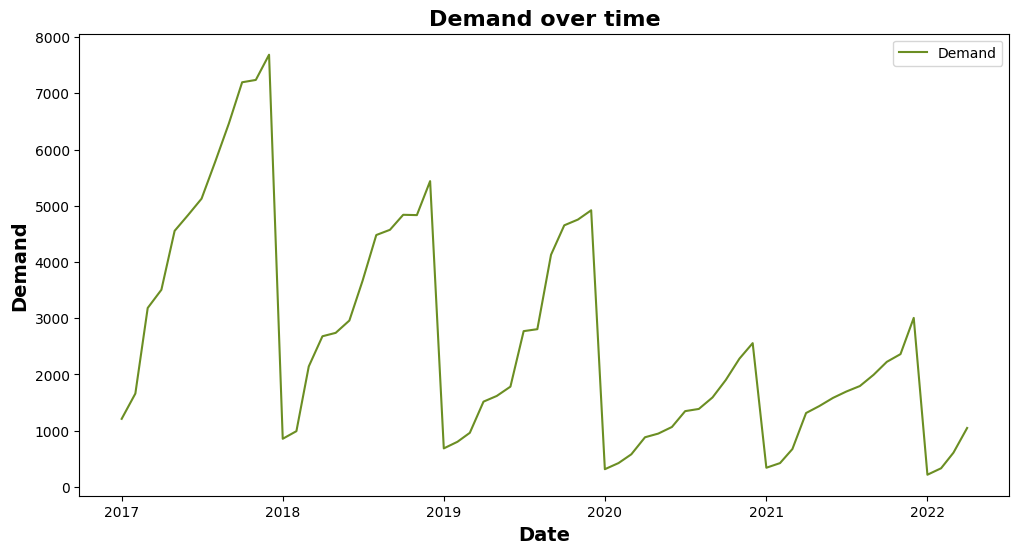

In [96]:
# Configurar el tamaño y resolución de la figura
plt.figure(figsize=(12, 6), dpi=100)

# Crear el gráfico de línea con Seaborn
sns.lineplot(data=data, x='Date', y='Demand', label='Demand', color='olivedrab')

# Añadir título y etiquetas
plt.title('Demand over time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Demand', fontsize=14, fontweight='bold')
plt.legend()

# Mostrar el gráfico
plt.show()

Los datos presentan estacionalidad, lo que indica patrones repetitivos en diferentes años.
Se muestra picos, correspondientes a periodos de alta demanda seguido de caídas, lo cual se puede deber a factores externos. 

# TRANSFORMACIÓN DE DATASET
Se transformaran los valores de demanda para que tengan media 0 y desviación estándar 1, facilitando el entrenamiento de modelos de Machine Learning al poner los datos en la misma escala.

In [ ]:
# normalizar la columna 'Demand' usando StandardScaler
standard_scaler = StandardScaler()
# Crear una copia del DataFrame original para evitar modificarlo directamente
df = data.copy()
# Normalizar la columna 'Demand' y asignar el resultado de vuelta a la columna 'Demand'
df['Demand'] = standard_scaler.fit_transform(df[['Demand']])

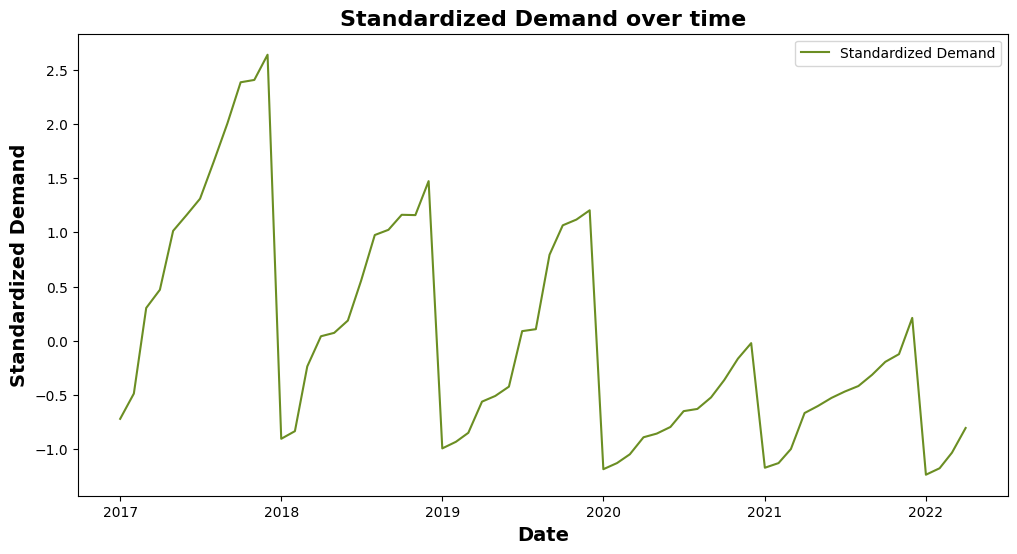

In [81]:
## visualizar la serie temporal estandarizada
plt.figure(figsize=(12, 6), dpi=100)
sns.lineplot(data=df, x='Date', y='Demand', label='Standardized Demand', color='olivedrab')
plt.title('Standardized Demand over time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Standardized Demand', fontsize=14, fontweight='bold')
plt.legend()
plt.show()

 ## Seasonal_decompose (Descomposición Estacional)
 Descompone una serie temporal en sus componentes:

Tendencia (movimiento a largo plazo).

Estacionalidad (patrones que se repiten en intervalos fijos).

Residual (ruido o variabilidad no explicada).

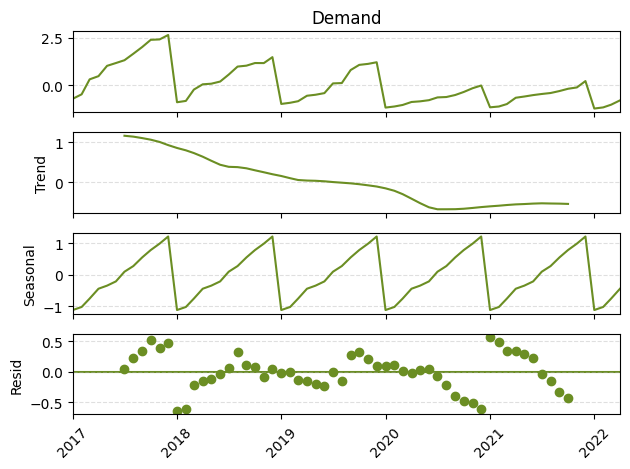

In [89]:
# Decompose the time series to visualize its components
descompose_data = seasonal_decompose(df['Demand'], model='additive', period=12)
fig = descompose_data.plot()
axes = fig.get_axes()

# (3) Iteras sobre cada uno de los 4 ejes y cambias el color de los 'lines' y 'collections'
color_deseado = 'olivedrab'

for ax in axes:
    # a) Si el gráfico usa líneas (serie, tendencia, estacionalidad),
    #    cada línea está en ax.get_lines(). Le asignamos el mismo color.
    for line in ax.get_lines():
        line.set_color(color_deseado)
        line.set_linewidth(1.5)

    # b) En el último panel (residuales), statsmodels dibuja "puntos" con ax.scatter(),
    #    que en Matplotlib aparecen como "collections". 
    #    Para cambiar color de esos marcadores, buscamos en ax.collections.
    for coll in ax.collections:
        coll.set_color(color_deseado)

    # c) Opcional: mantenemos la línea horizontal en y=0 (en el panel de residuales) en negro
    #    (statsmodels ya la dibuja, así que no hay que generar otra).

# (4) Si quieres agregarle grid a todos los ejes, por ejemplo:
for ax in axes:
    ax.grid(axis='y', linestyle='--', alpha=0.4)

# (5) Ajuste estético del eje x (rotar fechas) y mostrar
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


El gráfico nos muestra fluctuaciones cíclicas confirmando la estacionalidad de los datos, la serie presenta una tendencia descendente lo que nos puede estar indifcando un cambio en la demanda, ya que se nota una disminución entre los años 2018 hasta el 2021. Otra cosa para resaldar es una estabilidad entre los años 2021 y 2022, esto nos puede indicar que la serie podría estar llegando a un punto de equilibrio.
El componente del residuo nos muestra como los valores se encuentran en su mayoría centrados alrededor del cero, esto nos indica que el valor residual es relativamente pequeño en comparación con el efecto estacional. 

## Verifica el “split”

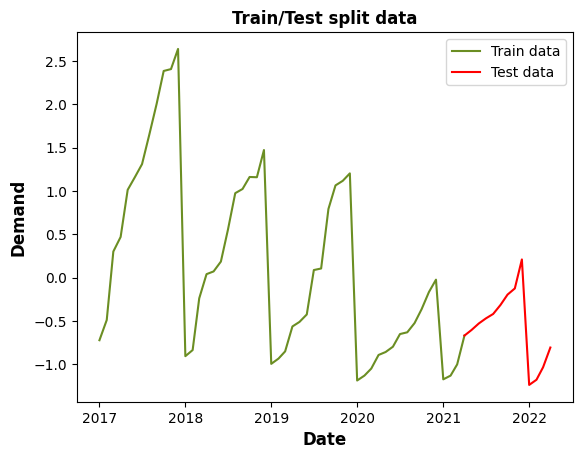

In [93]:
# verifica que el split de train/test sea correcto
train_size = int(len(df) * 0.8)
# Divide el DataFrame en conjuntos de entrenamiento y prueba
train_data, test_data = df.iloc[:train_size+1], df.iloc[train_size:]

# Visualizar el conjunto de entrenamiento y prueba
plt.plot(train_data, color='olivedrab', label='Train data')
plt.plot(test_data, color='red', label='Test data')
plt.ylabel('Demand', fontsize=12, fontweight='bold')
plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.title('Train/Test split data', fontsize=12, fontweight='bold')
plt.show()

# MODELOS
Data la estacionalidad de los datos se proponen usar cuatro modelos

### Holt–Winters (Triple Exponential Smoothing): 
Método de suavizado exponencial que modela simultáneamente nivel, tendencia y estacionalidad; ideal para series con ciclo fijo y tendencia suave.
### ARIMA (AutoRegressive Integrated Moving Average):
Combina autorregresión, diferenciación para estacionariedad y promedio móvil; apropiado cuando no hay estacionalidad fuerte o tras eliminarla manualmente.
### SARIMAX (Seasonal ARIMA con Exógenas)  
Extiende ARIMA incluyendo un componente estacional fijo (p,d,q)×(P,D,Q,s) y variables exógenas; recomendado para datos con estacionalidad clara y regresores adicionales.
### Prophet (Facebook/Meta)  
Modelo de tendencia “piecewise” con detección automática de puntos de cambio y múltiples estacionalidades (anual, semanal, festivos); útil para series con ciclos complejos y eventos especiales.



## Holt-Winters Model

In [56]:
hw_model = ExponentialSmoothing(train_data['Demand'], trend = 'add', seasonal = 'add', seasonal_periods=12)
hw_fit = hw_model.fit()
hw_pred = hw_fit.forecast(len(test_data))

hw_mse = mean_squared_error(test_data['Demand'], hw_pred)
hw_mae = mean_absolute_error(test_data['Demand'], hw_pred)
hw_rmse = np.sqrt(hw_mse)
hw_mape = mean_absolute_percentage_error(test_data['Demand'], hw_pred)

print(f'Holt-Winters Metrics: \nMSE = {hw_mse} \nMAE = {hw_mae} \nRMSE = {hw_rmse} \nMAPE = {hw_mape}')

Holt-Winters Metrics: 
MSE = 0.5325022436634496 
MAE = 0.5624636415359159 
RMSE = 0.7297275132975661 
MAPE = 2.2263374126447233


c:\Estudio\prueba_tecnica_gestor\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


## SARIMAX Model 


In [57]:
sarimax_model = SARIMAX(train_data['Demand'], order=(0, 0, 1), seasonal_order=(1, 0, 0, 12))
sarimax_fit = sarimax_model.fit()
sarimax_pred = sarimax_fit.predict(start=len(train_data), end=(len(train_data) + len(test_data) - 1), typ ='levels')

sarimax_mse = mean_squared_error(test_data['Demand'], sarimax_pred)
sarimax_mae = mean_absolute_error(test_data['Demand'], sarimax_pred)
sarimax_rmse = np.sqrt(sarimax_mse)
sarimax_mape = mean_absolute_percentage_error(test_data['Demand'], sarimax_pred)

print(f'SARIMAX Metrics: \nMSE = {sarimax_mse} \nMAE = {sarimax_mae} \nRMSE = {sarimax_rmse} \nMAPE = {sarimax_mape}')


SARIMAX Metrics: 
MSE = 0.14777588254206328 
MAE = 0.22131729937942926 
RMSE = 0.3844162880811156 
MAPE = 0.6573373289252129


c:\Estudio\prueba_tecnica_gestor\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Estudio\prueba_tecnica_gestor\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Estudio\prueba_tecnica_gestor\.venv\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


## ARIMA MODEL

In [58]:
arima_model = ARIMA(train_data['Demand'], order=(1, 1, 0))
arima_fit = arima_model.fit()
arima_pred = arima_fit.forecast(steps=len(test_data))

arima_mse = mean_squared_error(test_data['Demand'], arima_pred)
arima_mae = mean_absolute_error(test_data['Demand'], arima_pred)
arima_rmse = np.sqrt(arima_mse)
arima_mape = mean_absolute_percentage_error(test_data['Demand'], arima_pred)

print(f'ARIMA Metrics: \nMSE = {arima_mse} \nMAE = {arima_mae} \nRMSE = {arima_rmse} \nMAPE = {arima_mape}')


ARIMA Metrics: 
MSE = 0.17658740080885219 
MAE = 0.34773808154048097 
RMSE = 0.4202230369801877 
MAPE = 1.165605727995898


c:\Estudio\prueba_tecnica_gestor\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Estudio\prueba_tecnica_gestor\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Estudio\prueba_tecnica_gestor\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [59]:
#MODELO PROPHET
from prophet import Prophet
# Preparar los datos para Prophet
prophet_data = df.reset_index().rename(columns={'Date': 'ds', 'Demand': 'y'})
# Crear y ajustar el modelo Prophet
prophet_model = Prophet()
prophet_model.fit(prophet_data)
# Hacer predicciones
future = prophet_model.make_future_dataframe(periods=len(test_data), freq='M')
forecast = prophet_model.predict(future)
# Extraer las predicciones
prophet_pred = forecast['yhat'][-len(test_data):].values
# Calcular métricas de error
prophet_mse = mean_squared_error(test_data['Demand'], prophet_pred)
prophet_mae = mean_absolute_error(test_data['Demand'], prophet_pred)
prophet_rmse = np.sqrt(prophet_mse)
prophet_mape = mean_absolute_percentage_error(test_data['Demand'], prophet_pred)


print(f'Prophet MSE: \nMSE = {prophet_mse} \nMAE = {prophet_mae} \nRMSE = {prophet_rmse} \nMAPE = {prophet_mape}')


18:29:37 - cmdstanpy - INFO - Chain [1] start processing
18:29:37 - cmdstanpy - INFO - Chain [1] done processing


Prophet MSE: 
MSE = 0.9995535881854186 
MAE = 0.6983235725004708 
RMSE = 0.9997767691767091 
MAPE = 1.793402533882992


c:\Estudio\prueba_tecnica_gestor\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


# COMPARACIÓN DE LOS RESULTADOS

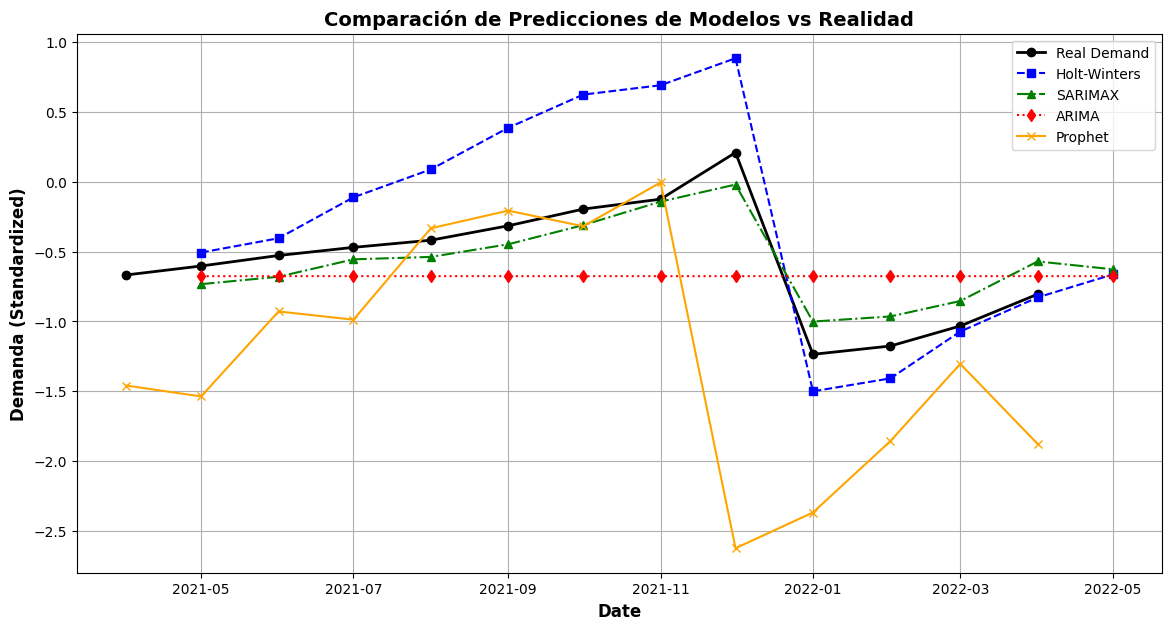

In [99]:
plt.figure(figsize=(14, 7), dpi=100)

# Plot real demand (test data)
plt.plot(test_data.index, test_data['Demand'], label='Real Demand', color='black', linewidth=2, marker='o')

# Plot Holt-Winters predictions
plt.plot(hw_pred.index, hw_pred.values, label='Holt-Winters', color='blue', linestyle='--', marker='s')

# Plot SARIMAX predictions
plt.plot(sarimax_pred.index, sarimax_pred.values, label='SARIMAX', color='green', linestyle='-.', marker='^')

# Plot ARIMA predictions
plt.plot(arima_pred.index, arima_pred.values, label='ARIMA', color='red', linestyle=':', marker='d')

# Plot Prophet predictions
plt.plot(test_data.index, prophet_pred, label='Prophet', color='orange', linestyle='-', marker='x')

plt.title('Comparación de Predicciones de Modelos vs Realidad', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Demanda (Standardized)', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

# TABLA DE RESULTADOS

In [63]:

#Tabla de resultados
results = pd.DataFrame({
    'Model': ['Holt-Winters', 'SARIMAX', 'ARIMA', 'Prophet'],
    'MSE': [hw_mse, sarimax_mse, arima_mse, prophet_mse],
    'MAE': [hw_mae, sarimax_mae, arima_mae, prophet_mae],
    'RMSE': [hw_rmse, sarimax_rmse, arima_rmse, prophet_rmse],
    'MAPE': [hw_mape, sarimax_mape, arima_mape, prophet_mape]
})
print('\nTabla de Resultados:')
print(results)


Tabla de Resultados:
          Model       MSE       MAE      RMSE      MAPE
0  Holt-Winters  0.532502  0.562464  0.729728  2.226337
1       SARIMAX  0.147776  0.221317  0.384416  0.657337
2         ARIMA  0.176587  0.347738  0.420223  1.165606
3       Prophet  0.999554  0.698324  0.999777  1.793403


Los resultados de la tabla muestran claramente que tanto ARIMA como Prophet presentan errores de validación (MSE, MAE, RMSE, MAPE) sustancialmente mayores que los de Holt–Winters y SARIMAX. En particular:

ARIMA: Aunque modela bien las dinámicas de autocorrelación, obtiene un MSE de 0.1766 y un RMSE de 0.4202, valores notablemente superiores a los de SARIMAX (MSE 0.1478, RMSE 0.3844). Además, su MAPE (1.1656) indica un error porcentual medio mayor que el modelo estacional.

Prophet (Facebook): Obtiene los peores indicadores de los cuatro—con un MSE de 0.9996, RMSE prácticamente igual a 1 y un MAPE de 1.7934 lo que revela que la detección automática de “changepoints” y la combinación de estacionalidades que propone Prophet no captura adecuadamente el patrón particular de la serie. 

Dado que nuestro objetivo es optimizar la precisión del pronóstico en los próximos tres meses, se decide descartar Prophet y concentrarse en los tres modelos que mostraron mejor desempeño.

### Forecasting de los próximos 3 meses

In [64]:
#forecastin con los tres mejores modelos
#forecasting modelo Holt-Winters
hw_pred_future = hw_fit.forecast(len(test_data) + 2)
hw_pred_future = hw_pred_future[-3:]

print(f'Holt-Winters forecasting for the next 3 months:\n{hw_pred_future}')

Holt-Winters forecasting for the next 3 months:
2022-05-01   -0.663182
2022-06-01   -0.560982
2022-07-01   -0.267616
Freq: MS, dtype: float64


In [65]:
#forecasting modelo SARIMAX
sarimax_pred_future = sarimax_fit.forecast(len(test_data) + 2)
sarimax_pred_future = sarimax_pred_future[-3:]
print(f'SARIMAX forecasting for the next 3 months:\n{sarimax_pred_future}')


SARIMAX forecasting for the next 3 months:
2022-05-01   -0.625771
2022-06-01   -0.580486
2022-07-01   -0.473873
Freq: MS, Name: predicted_mean, dtype: float64


In [66]:
#forecasting modelo ARIMA
arima_pred_future = arima_fit.forecast(len(test_data) + 2)
arima_pred_future = arima_pred_future[-3:]
print(f'ARIMA forecasting for the next 3 months:\n{arima_pred_future}')


ARIMA forecasting for the next 3 months:
2022-05-01   -0.67526
2022-06-01   -0.67526
2022-07-01   -0.67526
Freq: MS, Name: predicted_mean, dtype: float64


# TABULACIÓN DE LOS RESULTADOS

In [67]:
#CREAR UN NUEVO DATAFRAME CON LAS PREDICCIONES FUTURAS
future_dates = pd.date_range(start=test_data.index[-1] + pd.DateOffset(months=1), periods=3, freq='M')
future_df = pd.DataFrame({
    'Date': future_dates,
    'Holt-Winters': hw_pred_future,
    'SARIMAX': sarimax_pred_future,
    'ARIMA': arima_pred_future
})
future_df.set_index('Date', inplace=True)
print('\nFuture Predictions DataFrame:')
future_df



Future Predictions DataFrame:


C:\Users\damak\AppData\Local\Temp\ipykernel_34744\2393806815.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=test_data.index[-1] + pd.DateOffset(months=1), periods=3, freq='M')


,Holt-Winters,SARIMAX,ARIMA
Date,,,
2022-05-31,-0.663182,-0.625771,-0.67526
2022-06-30,-0.560982,-0.580486,-0.67526
2022-07-31,-0.267616,-0.473873,-0.67526


In [68]:
#crear copia de predicciones
data_predicciones = df.copy()
# Añadir las predicciones al DataFrame original
data_predicciones = pd.concat([df, future_df])
data_predicciones.tail() # ver las últimas filas del DataFrame con las predicciones


,Demand,Holt-Winters,SARIMAX,ARIMA
Date,,,,
2022-03-01,-1.032237,NaN,NaN,NaN
2022-04-01,-0.804438,NaN,NaN,NaN
2022-05-31,NaN,-0.663182,-0.625771,-0.67526
2022-06-30,NaN,-0.560982,-0.580486,-0.67526
2022-07-31,NaN,-0.267616,-0.473873,-0.67526


# RESULTADOS FINALES

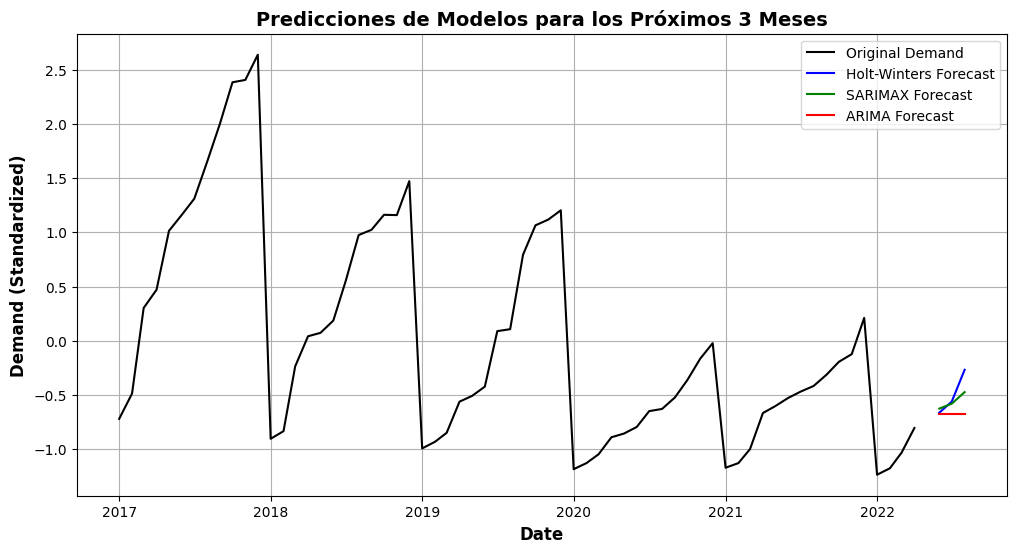

In [97]:
# Visualizar las predicciones de los modelos
plt.figure(figsize=(12, 6), dpi=100)
# Graficar la serie temporal original
sns.lineplot(data=df, x='Date', y='Demand', label='Original Demand', color='black')
# Graficar las predicciones de Holt-Winters
sns.lineplot(data=future_df, x=future_df.index, y='Holt-Winters', label='Holt-Winters Forecast', color='blue')  
# Graficar las predicciones de SARIMAX
sns.lineplot(data=future_df, x=future_df.index, y='SARIMAX', label='SARIMAX Forecast', color='green')
# Graficar las predicciones de ARIMA
sns.lineplot(data=future_df, x=future_df.index, y='ARIMA', label='ARIMA Forecast', color='red')
# Añadir título y etiquetas
plt.title('Predicciones de Modelos para los Próximos 3 Meses', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Demand (Standardized)', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True)
# Mostrar el gráfico
plt.show()

# Desnormalización

In [70]:
inversed_predictions = standard_scaler.inverse_transform(future_df)

df_inversed_predictions = pd.DataFrame(
    {
        'Holt-Winters': inversed_predictions[:, 0],
        'ARIMA': inversed_predictions[:, 1],
        'SARIMAX': inversed_predictions[:, 2]
    },
    index=future_dates
)
print('\nInversed Predictions DataFrame:')
print(df_inversed_predictions)


Inversed Predictions DataFrame:
            Holt-Winters        ARIMA      SARIMAX
2022-05-31   1320.933194  1393.089847  1297.638643
2022-06-30   1518.051615  1480.434173  1297.638643
2022-07-31   2083.880355  1686.062108  1297.638643


In [71]:
#concatener las predicciones inversas al DataFrame original
data_inversed_predictions = pd.concat([data, df_inversed_predictions])
print('\nDataFrame with Inversed Predictions:')
data_inversed_predictions.tail()  # ver las últimas filas del DataFrame con las predicciones inversas



DataFrame with Inversed Predictions:


,Demand,Holt-Winters,ARIMA,SARIMAX
2022-03-01,609.119726,NaN,NaN,NaN
2022-04-01,1048.486287,NaN,NaN,NaN
2022-05-31,NaN,1320.933194,1393.089847,1297.638643
2022-06-30,NaN,1518.051615,1480.434173,1297.638643
2022-07-31,NaN,2083.880355,1686.062108,1297.638643


# VISUALIZACIÓN DE LOS RESULTADOS

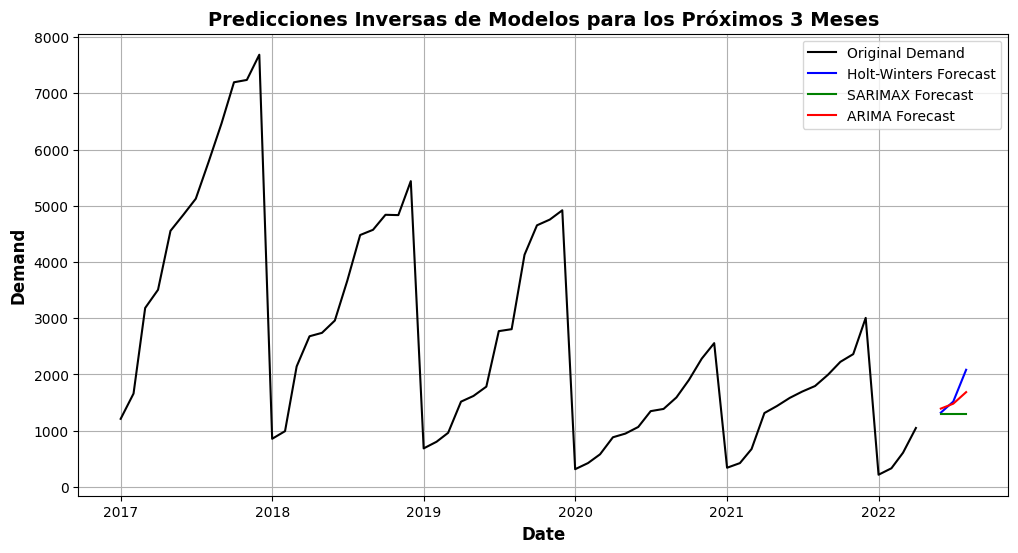

In [98]:
plt.figure(figsize=(12, 6), dpi=100)
# Graficar la serie temporal original
sns.lineplot(data=data_inversed_predictions, x=data_inversed_predictions.index, y='Demand', label='Original Demand', color='black')
# Graficar las predicciones de Holt-Winters
sns.lineplot(data=df_inversed_predictions, x=df_inversed_predictions.index, y='Holt-Winters', label='Holt-Winters Forecast', color='blue')
# Graficar las predicciones de SARIMAX
sns.lineplot(data=df_inversed_predictions, x=df_inversed_predictions.index, y='SARIMAX', label='SARIMAX Forecast', color='green')
# Graficar las predicciones de ARIMA
sns.lineplot(data=df_inversed_predictions, x=df_inversed_predictions.index, y='ARIMA', label='ARIMA Forecast', color='red')
# Añadir título y etiquetas
plt.title('Predicciones Inversas de Modelos para los Próximos 3 Meses', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Demand', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True)
# Mostrar el gráfico
plt.show()